## Title : Implement the Continuous Bag of Words (CBOW) Model.

### Aim: Implement the Continuous Bag of Words (CBOW) Model. Stages can be:

a. Data preparation

b. Generate training data

c. Train model

d. Output

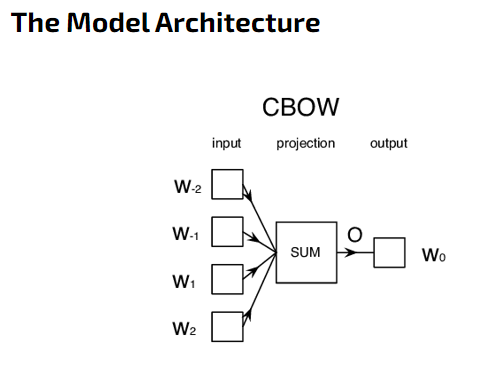

In [1]:
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing import text
from keras.utils import pad_sequences
import pandas as pd

In [3]:
#!pip install gensim

In [20]:
data=open('te.txt','r')
corona_data = [text for text in data if text.count(' ') >= 2]
dataa=str(corona_data)
dl_data=dataa.split()
dl_data

['["this',
 'is',
 'my',
 'story',
 'where',
 "i'm",
 'the',
 'hero',
 'with',
 'an',
 'evil',
 'side',
 'features.',
 'I',
 'do',
 'it',
 'better',
 'in',
 'all',
 'ways',
 'just',
 'need',
 'some',
 'one',
 'to',
 'try',
 'on.',
 'Come',
 'bae',
 'lets',
 'burn',
 'down',
 'a',
 "lil'",
 'bit."]']

In [10]:
#tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dl_data)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in dl_data]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 36
Vocabulary Sample: [('this', 1), ('is', 2), ('my', 3), ('story', 4), ('where', 5), ("i'm", 6), ('the', 7), ('hero', 8), ('with', 9), ('an', 10)]


In [12]:
#generating (context word, target/label word) pairs
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)
            
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        # print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

In [13]:
#model building
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='adam')

print(cbow.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4, 100)            3600      
                                                                 
 lambda (Lambda)             (None, 100)               0         
                                                                 
 dense (Dense)               (None, 36)                3636      
                                                                 
Total params: 7,236
Trainable params: 7,236
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
for epoch in range(1, 100):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Epoch: 1 	Loss: 125.10110878944397

Epoch: 2 	Loss: 125.07228922843933

Epoch: 3 	Loss: 125.04632592201233

Epoch: 4 	Loss: 125.02287244796753

Epoch: 5 	Loss: 125.00163269042969

Epoch: 6 	Loss: 124.98234820365906

Epoch: 7 	Loss: 124.96479344367981

Epoch: 8 	Loss: 124.94876980781555

Epoch: 9 	Loss: 124.93410897254944

Epoch: 10 	Loss: 124.92065525054932

Epoch: 11 	Loss: 124.90828037261963

Epoch: 12 	Loss: 124.89686489105225

Epoch: 13 	Loss: 124.88631343841553

Epoch: 14 	Loss: 124.87652778625488

Epoch: 15 	Loss: 124.86743307113647

Epoch: 16 	Loss: 124.85896277427673

Epoch: 17 	Loss: 124.85104894638062

Epoch: 18 	Loss: 124.84364461898804

Epoch: 19 	Loss: 124.8366961479187

Epoch: 20 	Loss: 124.83016467094421

Epoch: 21 	Loss: 124.82400703430176

Epoch: 22 	Loss: 124.81819343566895

Epoch: 23 	Loss: 124.81269454956055

Epoch: 24 	Loss: 124.80747961997986

Epoch: 25 	Loss: 124.80252575874329

Epoch: 26 	Loss: 124.79781222343445

Epoch: 27 	Loss: 124.79331851005554

Epoch: 28 	

In [17]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[1:]).head()

(35, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
is,0.022865,-0.026218,0.000456,0.001937,-0.027345,-0.046229,0.028952,0.006959,0.007163,0.046393,...,-0.038018,-0.022935,0.047998,0.046933,-0.008701,-0.039630,0.008230,-0.049611,-0.016469,-0.037998
my,-0.035464,0.001905,0.024310,0.041680,0.025410,0.008620,-0.025123,-0.034677,-0.029189,0.046902,...,-0.013038,0.007661,-0.002087,0.026789,-0.003658,0.023162,-0.028302,-0.009120,0.035195,0.012804
story,0.009784,-0.021486,-0.046851,0.037410,0.011753,0.000677,-0.018716,-0.016049,0.003775,-0.024714,...,0.041653,0.013797,0.020174,-0.015959,-0.006015,-0.020684,-0.048975,0.044814,-0.008560,0.047923
where,-0.031250,-0.018792,0.036604,-0.047929,-0.033390,-0.020317,-0.026645,0.011654,0.018618,0.047157,...,0.004831,-0.039659,0.009936,-0.030078,0.001490,-0.020227,-0.003705,0.033323,-0.010368,0.017621
i'm,-0.009640,-0.040725,0.005536,-0.011275,-0.032150,-0.045798,-0.007071,-0.028854,-0.023202,-0.044546,...,0.047672,0.027355,0.026393,-0.018384,-0.036894,0.049686,-0.020748,-0.034766,0.024081,-0.007891


In [19]:
from sklearn.metrics.pairwise import euclidean_distances

distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['my']}

similar_words

(35, 35)


{'my': ['try', 'the', 'in', 'is', 'evil']}